# Questions 1c-e

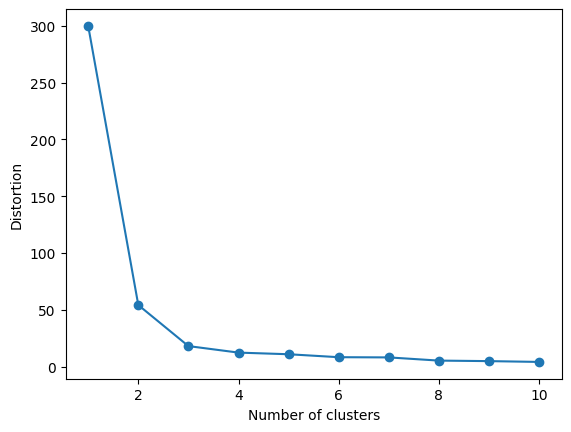

In [1]:
# Week10 
# Question 1 (c)
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()
# We only use the "petal width" & "petal length" columns
iris_data_wl = pd.DataFrame(data=iris.data, columns=iris.feature_names)[['petal width (cm)','petal length (cm)']]

# Scale the length and width
scaler = StandardScaler()
x_scaled = scaler.fit_transform(iris_data_wl)

distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,n_init='auto', random_state=0)
    kmeans.fit(x_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

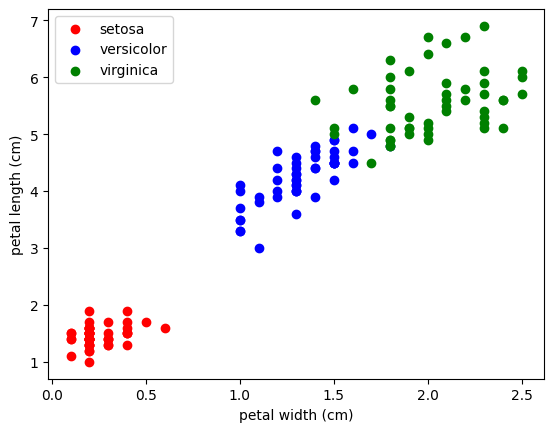

In [2]:
# Question 1 (d)

import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Our previous iris_data did not contain class, so let's add it 
iris_data_wl['class'] = iris.target

# Set up the plot
fig, ax = plt.subplots()

# Plot the data points for each class with a different color
for label, color in zip(range(3), ['red', 'blue', 'green']):
    mask = (iris_data_wl['class'] == label)
    ax.scatter(iris_data_wl.loc[mask, 'petal width (cm)'], iris_data_wl.loc[mask, 'petal length (cm)'], 
               c=color, label=iris.target_names[label])

# Add axis labels and legend
ax.set_xlabel('petal width (cm)')
ax.set_ylabel('petal length (cm)')
ax.legend()

# Show the plot
plt.show()

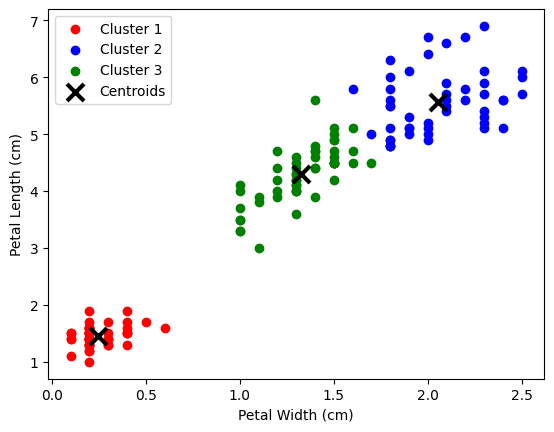

In [3]:
# Question 1 (e)

kmeans = KMeans(n_clusters=3,n_init=20, max_iter=300, init='k-means++')
# Notice here the kmeans is fitted using the scaled petal width and length
kmeans.fit(x_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Since the kmeans is fitted on the scalled value, but we normally want to show how the cluster is formed
# under the regular scale of the petal width and length, so the centroids of the plot need to be inverse scaled to the
# original scale/value
origin_centroids = scaler.inverse_transform(centroids)

# Visualize the resulting clusters with centroids
fig, ax = plt.subplots()

for label, color in zip(range(3), ['red', 'blue', 'green']):
    mask = (labels == label)
    ax.scatter(iris_data_wl.loc[mask, 'petal width (cm)'], iris_data_wl.loc[mask, 'petal length (cm)'], 
               c=color, label=f'Cluster {label+1}')

ax.scatter(origin_centroids[:, 0], origin_centroids[:, 1], s=150, marker='x', linewidths=3, color='black', label='Centroids')

ax.set_xlabel('Petal Width (cm)')
ax.set_ylabel('Petal Length (cm)')
ax.legend()

plt.show()

In [4]:
def KMeansPlusPlusLabels():
    return labels

# Question 2a-b


## Q2: DBSCAN algorithm:

### <span style='background:yellow'>(a)</span> How does it determine core points, border points, and noise points?

#### 1. Determine core points:
Core points in DBSCAN are specified by `2 hyperparmeter`:
- `Epsilon:` the radius of the circle to be created around each instance to check the density;
- `Min Neighbours:` the minimum number of neighbours required to be inside that circle

If an instance data point has at least min neighbours inside the given distance of Epsilon, we can say that instance is a core point.


#### 2. Determine border points:
A point can be determined as a border point if it is reachable from a core point but there are less than MinNeighbours number of points within its surrounding circle area


#### 3. Determine noise points:
A point cab be determined as noisy point (outlier) if it is not a core point and not reachable from any core points.

---

### <span style='background:yellow'>(b)</span> Write Python code to implement DBSCAN clustering using the same features as before and visualize the resulting clusters

#### 1. Loading data

In [5]:
# Load data:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
iris = load_iris()

# select the 2 required features
iris_df = pd.DataFrame(data = iris['data'], columns = iris['feature_names']).iloc[:, -2:]
iris_df.head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


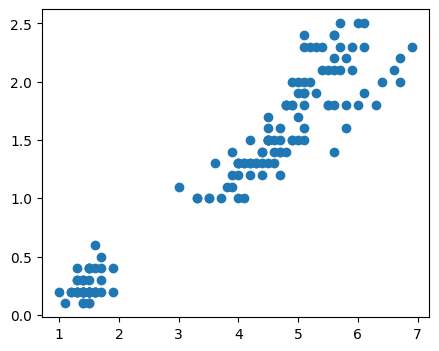

In [6]:
# Visualize the data:
import numpy as np
import matplotlib.pyplot as plt
X = iris_df.to_numpy()
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

---
#### 2. Determine optimal `Epsilon`:
To determine the best epsilon value, we 
- First calculate the `average distance` between each point and its nearest neighbors;
- Then plot a k-distance: 
    - y-axis: we plot the average distances
    - x-axis: all the data points in dataset.
- Finally choose the epsilon value at the `elbow` of the graph. 

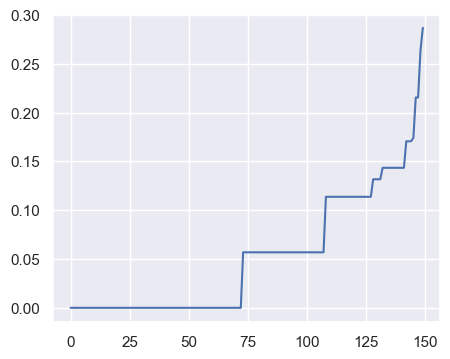

In [7]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(iris_df)
X_recover = scaler.inverse_transform(X)

from sklearn.neighbors import NearestNeighbors
import seaborn as sns
sns.set()
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(5, 4))
plt.plot(distances)

There are several elbow points here, we would say 0.15 looks better than the others, as this point has the maximum curvature. 
In the next section we also show the result of other epsilon values (0.05, 0.12, 0.15, 0.3) to prove why 0.15 is the best. 

---
#### 3. Determine optimal `minPts`:
- The larger the data set, the larger the value of MinPts should be
- If the data set is noisier, choose a larger value of MinPts
- Generally, MinPts should be >= the dimensionality of the data set
- For 2-dimensional data, use DBSCAN’s default value of MinPts = 4
- If your data has more than `2 dimensions`, choose `MinPts = 2*dim`, where dim= the dimensions of your data set

In our case, we only have 2 dimensions (petal length & width), so we set `MinPts = 4`

---
#### 4. Compute the DBSCAN

In [8]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

# scale the petal width & length for clustering
scaler = StandardScaler()
X = scaler.fit_transform(iris_df)

# retain the original unscaled data for final visualization
X_recover = scaler.inverse_transform(X)

# start the DBSCAN computing
db_005 = DBSCAN(eps=.05, min_samples=4).fit(X)
db_012 = DBSCAN(eps=.12, min_samples=4).fit(X)
db_015 = DBSCAN(eps=.15, min_samples=4).fit(X)
db_030 = DBSCAN(eps=.30, min_samples=4).fit(X)

labels_005 = db_005.labels_
labels_012 = db_012.labels_
labels_015 = db_015.labels_
labels_030 = db_030.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_005 = len(set(labels_005)) - (1 if -1 in labels_005 else 0)
n_clusters_012 = len(set(labels_012)) - (1 if -1 in labels_012 else 0)
n_clusters_015 = len(set(labels_015)) - (1 if -1 in labels_015 else 0)
n_clusters_030 = len(set(labels_030)) - (1 if -1 in labels_030 else 0)

n_noise_005 = list(labels_005).count(-1)
n_noise_012 = list(labels_012).count(-1)
n_noise_015 = list(labels_015).count(-1)
n_noise_030 = list(labels_030).count(-1)

table = [[n_clusters_005, n_noise_005],
         [n_clusters_012, n_noise_012],
         [n_clusters_015, n_noise_015],
         [n_clusters_030, n_noise_030]
        ]
df = pd.DataFrame(table, 
                  columns = ['Estimated number of clusters', 'Estimated number of noise points'], 
                  index=['eps = .05', 'eps = .12', 'eps = .15', 'eps = .30'])
print(df)

           Estimated number of clusters  Estimated number of noise points
eps = .05                             5                               121
eps = .12                            14                                42
eps = .15                             5                                16
eps = .30                             2                                 0


This summary already gives us some ideas about the optimal epsilon:
- If epsilon is chosen much too small, a large part of the data will not be clustered
    - e.g.: eps =.05, with very highnoise points 121
- Whereas a high epsilon value clusters will merge and the majority of data points will be in the same cluster
    - e.g.: eps = .30, only 2 clusters and all noise points are inluded

In general, small values of epsilon are preferable, and as a rule of thumb, only a small fraction of points should be within this distance of each other.

---
#### 5. Visualize our result

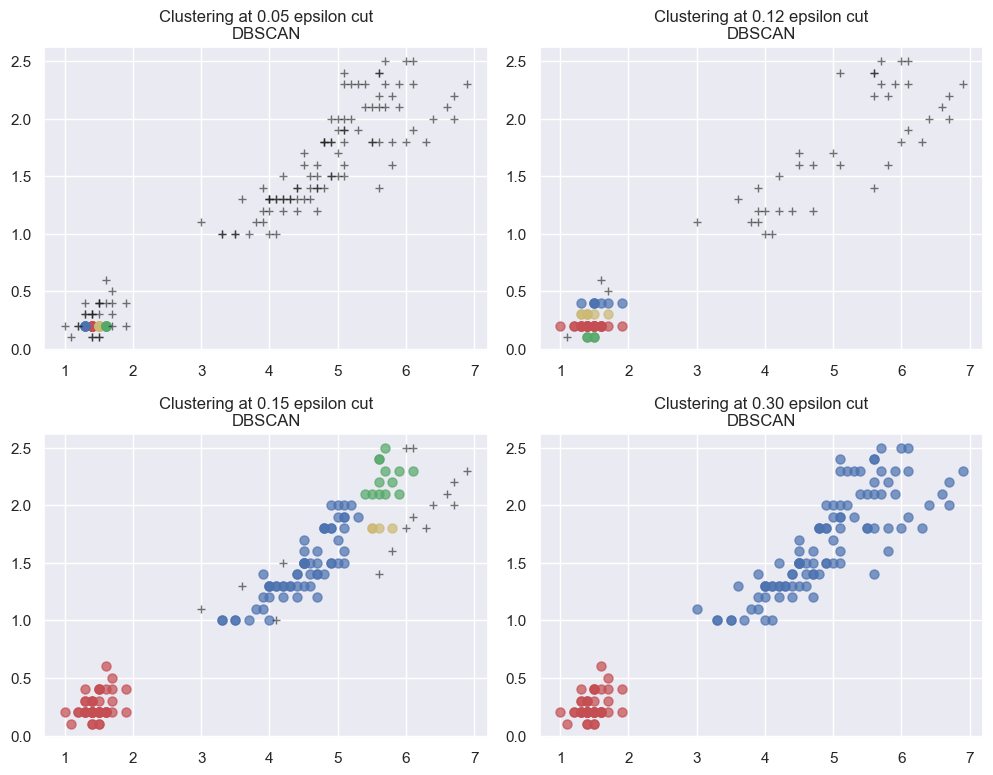

In [9]:
# (NOTE: visualize by original data X_recover, rather than the scaled one)
plt.figure(figsize=(20, 15))
G = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(G[1, 0])
ax2 = plt.subplot(G[1, 1])
ax3 = plt.subplot(G[2, 0])
ax4 = plt.subplot(G[2, 1])

# DBSCAN at eps = 0.05
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_005 == klass]
    ax1.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax1.plot(X_recover[labels_005 == -1, 0], X_recover[labels_005 == -1, 1], "k+", alpha=0.6)
ax1.set_title("Clustering at 0.05 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.12
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_012 == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax2.plot(X_recover[labels_012 == -1, 0], X_recover[labels_012 == -1, 1], "k+", alpha=0.6)
ax2.set_title("Clustering at 0.12 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.15
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_015 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax3.plot(X_recover[labels_015 == -1, 0], X_recover[labels_015 == -1, 1], "k+", alpha=0.6)
ax3.set_title("Clustering at 0.15 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.30
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_030 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax4.plot(X_recover[labels_030 == -1, 0], X_recover[labels_030 == -1, 1], "k+", alpha=0.6)
ax4.set_title("Clustering at 0.30 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In conclusion, maybe `0.15 is the optimal epsilon` for our case, which is not underfitting with too many outliers and also not overfitting with inludint all noises.

In [10]:
def DbscanLabels():
    return labels_015

# Question 3d

In [11]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
# Import the dataset
from sklearn import datasets
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:4] # We only use the "petal width" & "petal length" features


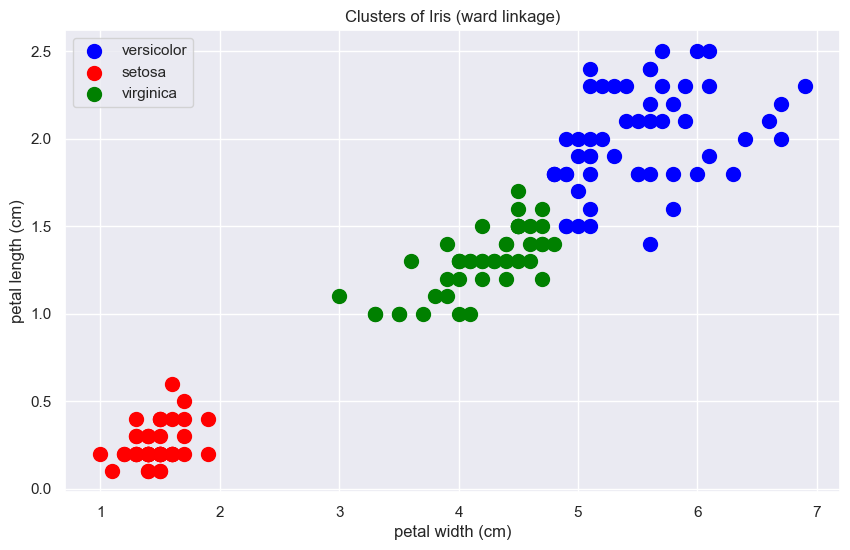

In [13]:
# Train the hierarcial clustering model on the dataset - using the ward linkage (minimises the variance of the clusters being merged)
from sklearn.cluster import AgglomerativeClustering
hc_ward = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
clusters = hc_ward.fit_predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s = 100, c = 'blue', label = 'versicolor')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s = 100, c = 'red', label = 'setosa')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s = 100, c = 'green', label = 'virginica')

plt.title('Clusters of Iris (ward linkage)')
plt.xlabel('petal width (cm)')
plt.ylabel('petal length (cm)')
plt.legend()
plt.show()

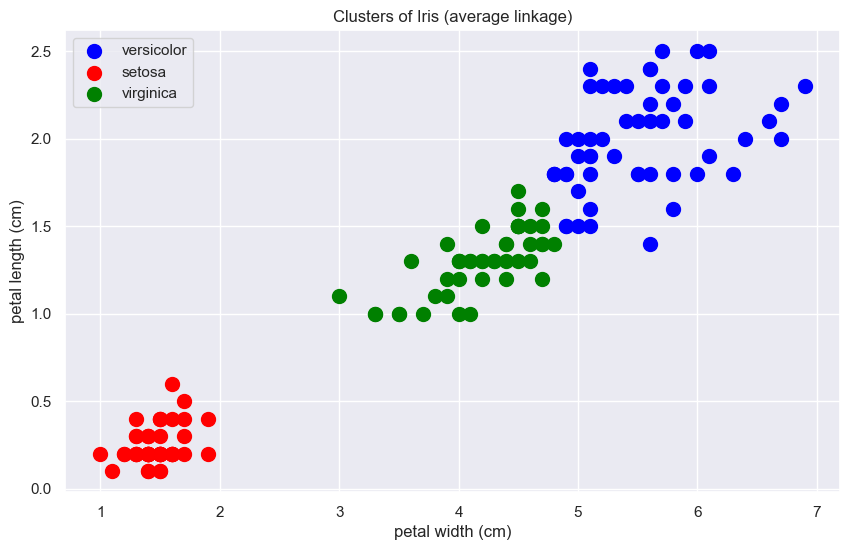

In [14]:
# Train the hierarcial clustering model on the dataset - using the average linkage (uses the average of the distances of each observations of the two sets
hc_average = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'average')
clusters = hc_average.fit_predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s = 100, c = 'blue', label = 'versicolor')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s = 100, c = 'red', label = 'setosa')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s = 100, c = 'green', label = 'virginica')

plt.title('Clusters of Iris (average linkage)')
plt.xlabel('petal width (cm)')
plt.ylabel('petal length (cm)')
plt.legend()
plt.show()

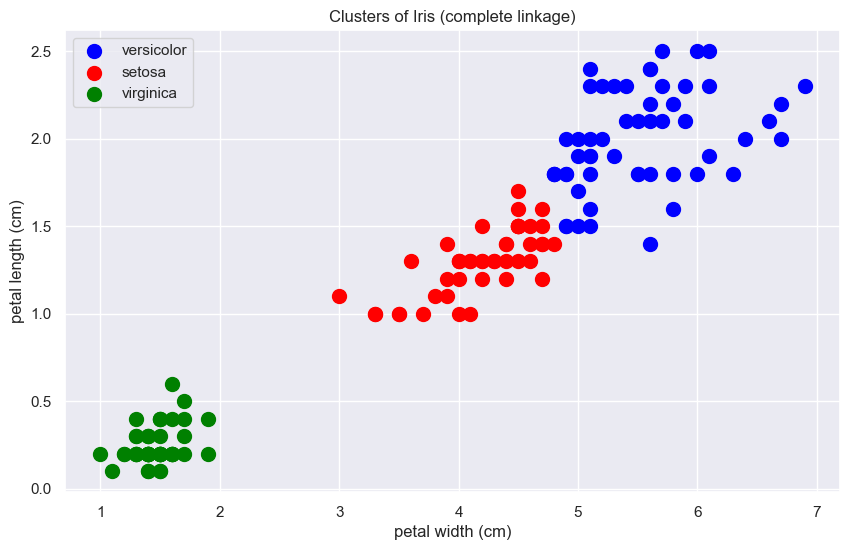

In [15]:
# Train the hierarcial clustering model on the dataset - using the complete linkage (uses the maximum distances between all of the observations of the two sets
hc_complete = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'complete')
clusters = hc_complete.fit_predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s = 100, c = 'blue', label = 'versicolor')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s = 100, c = 'red', label = 'setosa')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s = 100, c = 'green', label = 'virginica')

plt.title('Clusters of Iris (complete linkage)')
plt.xlabel('petal width (cm)')
plt.ylabel('petal length (cm)')
plt.legend()
plt.show()

# The complete linkage does not appear to be a good method for this dataset, as it has swapped setosa and virginica

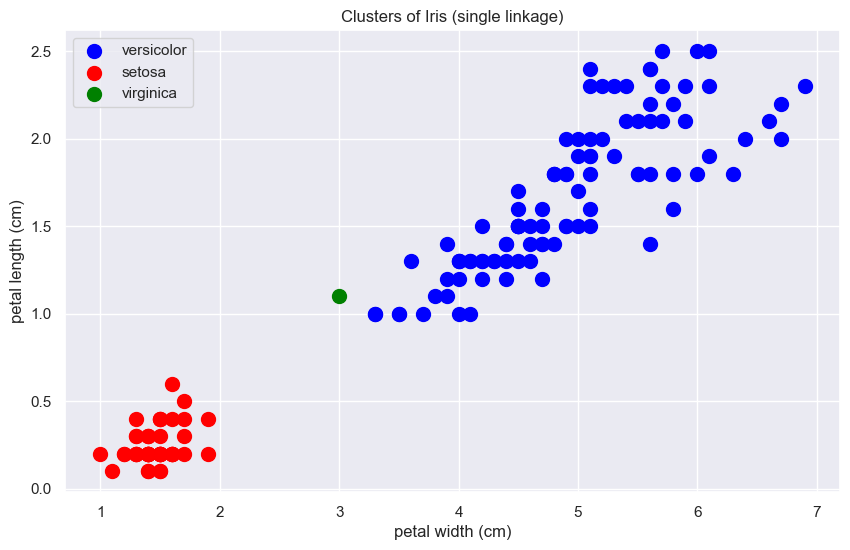

In [16]:
# Train the hierarcial clustering model on the dataset - using the single linkage (uses the minimum distances between all of the observations of the two sets
hc_single = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'single')
clusters = hc_single.fit_predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s = 100, c = 'blue', label = 'versicolor')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s = 100, c = 'red', label = 'setosa')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s = 100, c = 'green', label = 'virginica')

plt.title('Clusters of Iris (single linkage)')
plt.xlabel('petal width (cm)')
plt.ylabel('petal length (cm)')
plt.legend()
plt.show()

# The single linkage is the least effective method for this dataset, as it does not clearly define virginica and versicolor

In [17]:
def AgnesAverageLabels():
    clustering = hc_average.fit(X)
    return clustering.labels_

# Question 4

All we're doing here is doing a little bit of an evaluation between clustering techniques via [adjusted random score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) and [silhouette score score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). We will compare the true labels with respective clustering results from earlier questions.

- KMeans++
- DBScan (on the recommended epsilon 0.15 tuned version)
- Agnes (using the 'average' linkage criterion)

We have just attached some function definitions to each relevent sections to return the built labels of each technique.

In [18]:
from sklearn.datasets import load_iris
from sklearn.metrics import adjusted_rand_score

k_means_labels = KMeansPlusPlusLabels()
dbscan_labels = DbscanLabels()
agnes_labels = AgnesAverageLabels()

true_labels = iris.target

print(f"Adjusted random score (KMeans++): {adjusted_rand_score(true_labels, k_means_labels)}")
print(f"Adjusted random score (AGNES): {adjusted_rand_score(true_labels, agnes_labels)}")
print(f"Adjusted random score (DBSCAN): {adjusted_rand_score(true_labels, dbscan_labels)}")

Adjusted random score (KMeans++): 0.8856970310281228
Adjusted random score (AGNES): 0.8857921001989628
Adjusted random score (DBSCAN): 0.6026832821070386


_NOTE: no label alignment is nessecary, the paritioning is what matters to this metric utility._

## Interpretation of Adjusted Random Scores

[Recall that](https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score) the ARI has a range of -0.5 to 1. A score closer to 1 indicates that the two data clusterings are identical. ARI of 0 indicates the result is no better than random clustering, below that and approaching -0.5, we would deem the clustering increasingly dissimilar.

The KMeans++ and AGNES clustering algorithms both have ARIs close to 1 (difference between the two not significant enough to distinguish), suggesting that these algorithms did well replicating the underlying clustering structure of the iris dataset. The DBSCAN algorithm is cearly lagging behind, although acording to the index interpretation I gave above; still a decent score (it's well above 0, so better than random).

In [19]:
from sklearn.metrics import silhouette_score

features = iris_data_wl

print(f"Silhouette score (KMeans++): {silhouette_score(features, k_means_labels, metric='euclidean')}")
print(f"Silhouette score (AGNES): {silhouette_score(features, agnes_labels, metric='euclidean')}")
print(f"Silhouette score (DBSCAN): {silhouette_score(features, dbscan_labels, metric='euclidean')}")

Silhouette score (KMeans++): 0.6805967144842854
Silhouette score (AGNES): 0.6878490590116971
Silhouette score (DBSCAN): 0.4298292071781771


## Interpretation of Silhouette Coefficients

Recall that the the silhouette coefficient is a measure for the distance within a cluster and between clusters. Specifically combining the two properties of the clustering, that is given a point x; how **compact** the cluster Ci to which x belongs _and_ how **separated** the cluster Ci to which x belongs from all other points of nearest clusters.

We keep it euclidean here since we are dealing with features of comparable units (and since it's the typically used measure for defining distance).

The Silhouette Score supports our findings on the ARI above: clearly the KMeans++ and AGNES algorithms seem to have done a better job at clustering the data, while DBSCAN performed less well for this particular dataset or task. 

All of this doesn't necessarily mean that KMeans++ and AGNES are better algorithms in general, just that they were better suited to this specific task.